# Modelling the interval of Low and High with VARIMAX with additional features

# Imports

In [129]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

# Monthly data

Load datasets

In [130]:
monthly_M2_SP = pd.read_excel('./data/extended_data_monthly.xlsx')
sp500 = pd.read_csv('./data/monthly_M2_SP.csv')
monthly_M2_SP['Date'] =  pd.to_datetime(monthly_M2_SP['Date'], format='%Y-%m-%d')
sp500['Date'] =  pd.to_datetime(sp500['Date'], format='%Y-%m-%d')
monthly_M2_SP = monthly_M2_SP.merge(sp500, on='Date')
monthly_M2_SP.set_index('Date', inplace=True)
monthly_M2_SP.to_csv('./data/extended_data_monthly.csv')
monthly_M2_SP.drop(['Open','Close','Volume'],axis=1,inplace=True)
FEATURES = ['CPI', 'E INFL', 'GDP growth', 'retail food services', 'PPI',
       'Risk Premium', 'QE', 'Real interest rate', 'unemployment', 'oil', 'M2NS']
monthly_M2_SP.head()

,CPI,E INFL,GDP growth,retail food services,PPI,Risk Premium,QE,Real interest rate,unemployment,oil,High,Low,M2NS
Date,,,,,,,,,,,,,
2002-12-01,2.376910,1.951158,0.111308,293947,4.8,1.264753,725800.50,1.692254,6.0,28.33,954.28,869.45,5804.0
2003-01-01,2.597403,2.079012,3.326408,295248,6.8,1.196914,724718.40,1.488202,5.8,31.18,935.05,840.34,5793.5
2003-02-01,2.980877,2.106538,1.700788,291167,9.2,1.177252,721326.00,1.466379,5.9,32.77,864.64,806.29,5820.8
2003-03-01,3.020134,1.903343,2.964778,296325,11.4,1.151881,723651.25,1.223591,5.9,30.61,895.90,788.90,5882.1
2003-04-01,2.224694,1.989513,2.253233,295600,6.0,1.192092,736926.40,1.309618,6.0,25.00,924.24,847.85,5938.5


# Seasonality

<Axes: xlabel='Date'>

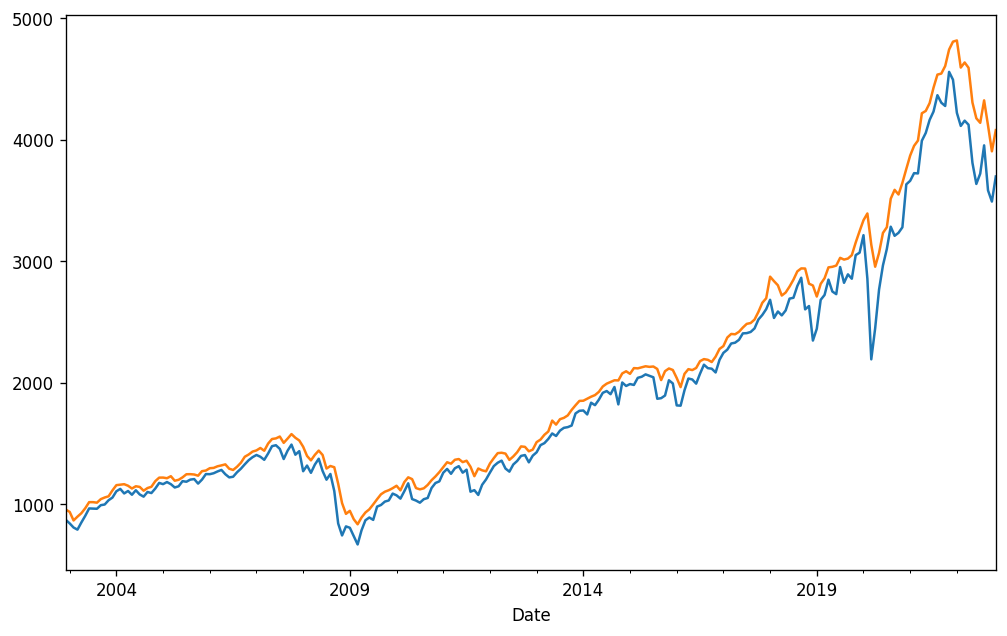

In [131]:
monthly_M2_SP['Low'].plot()
monthly_M2_SP['High'].plot()

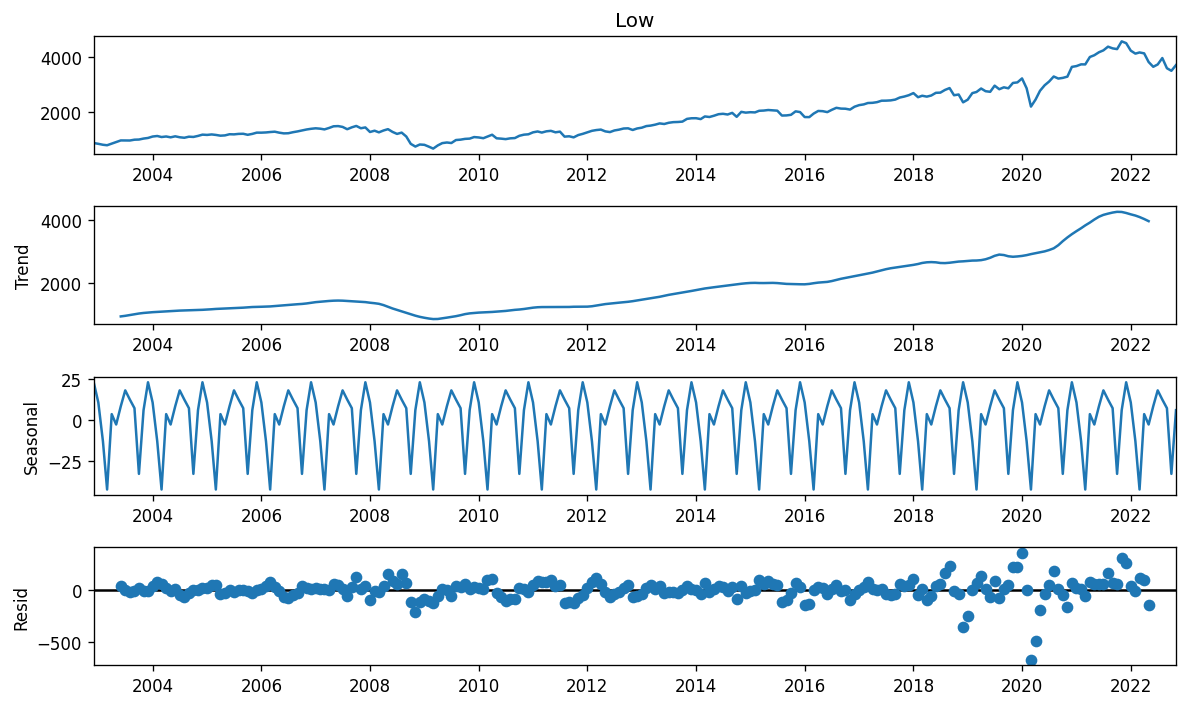

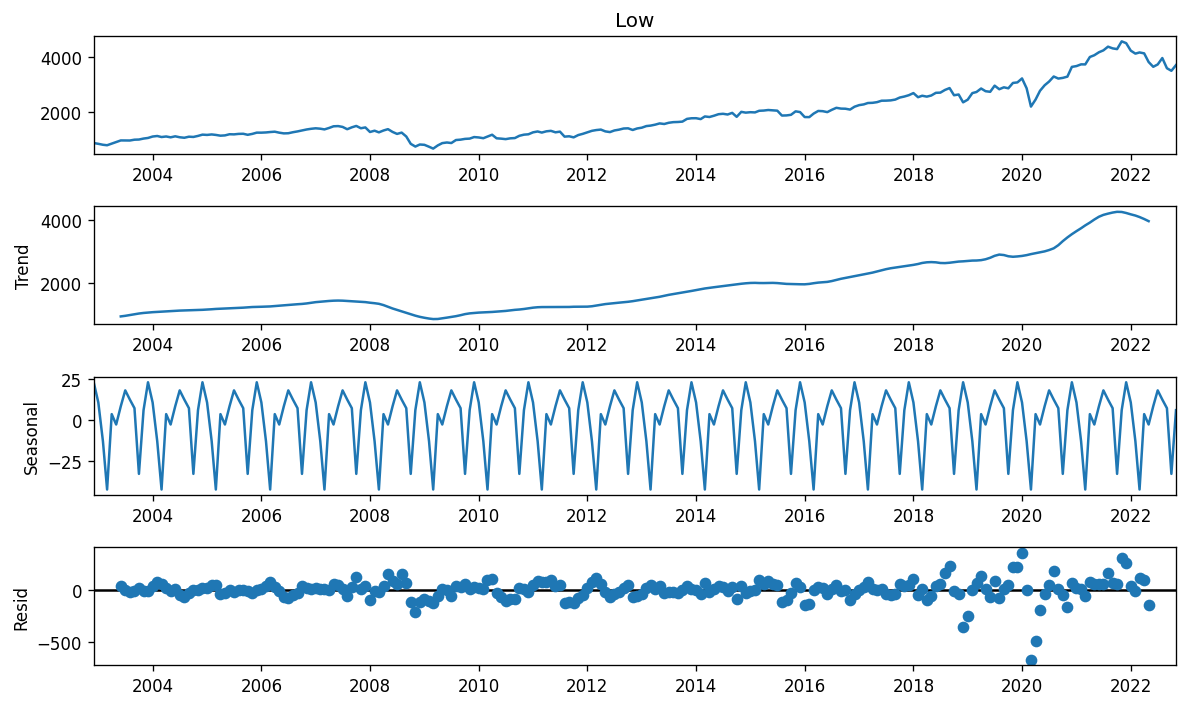

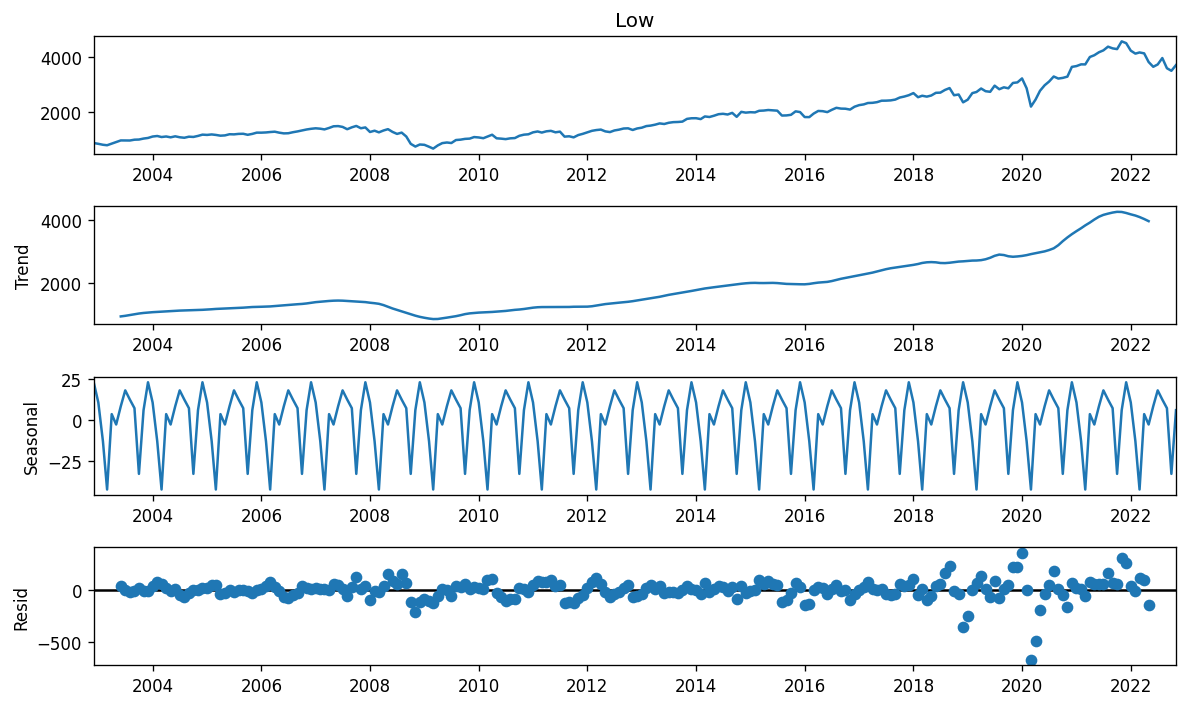

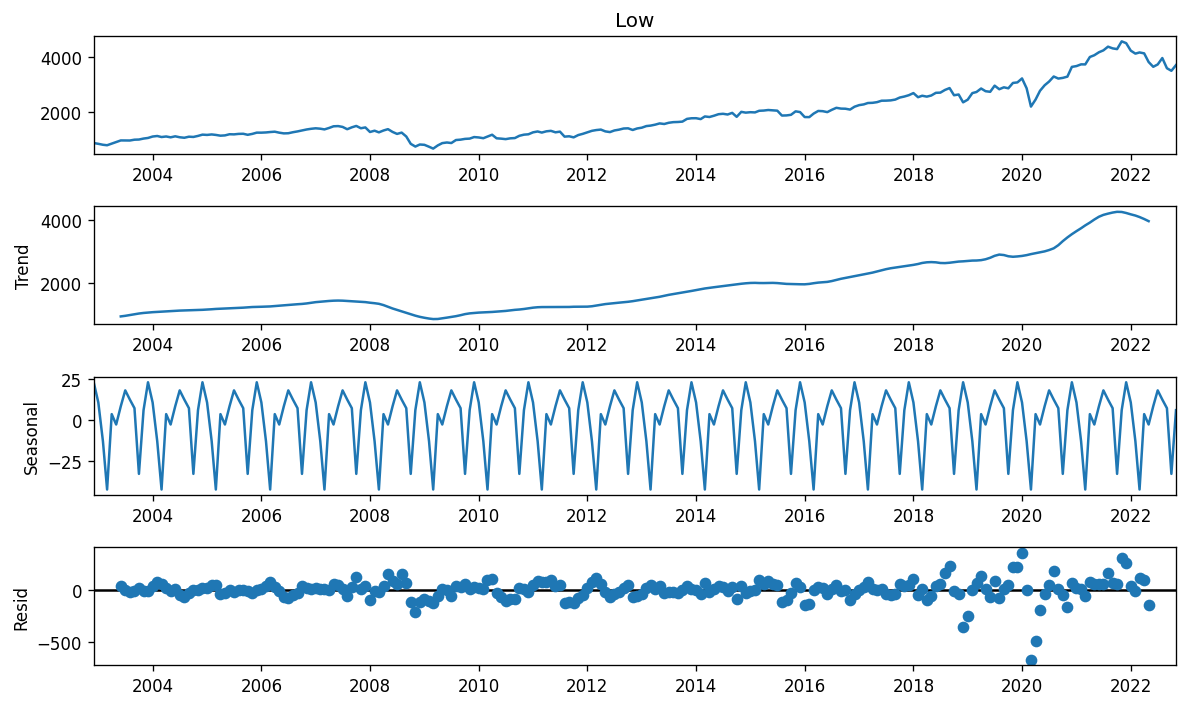

In [132]:
display(sm.tsa.seasonal_decompose(monthly_M2_SP['Low'],model='additive').plot())
display(sm.tsa.seasonal_decompose(monthly_M2_SP['Low'],model='additive').plot())
# sm.tsa.seasonal_decompose(monthly_M2_SP['Low'],model='additive').seasonal.plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

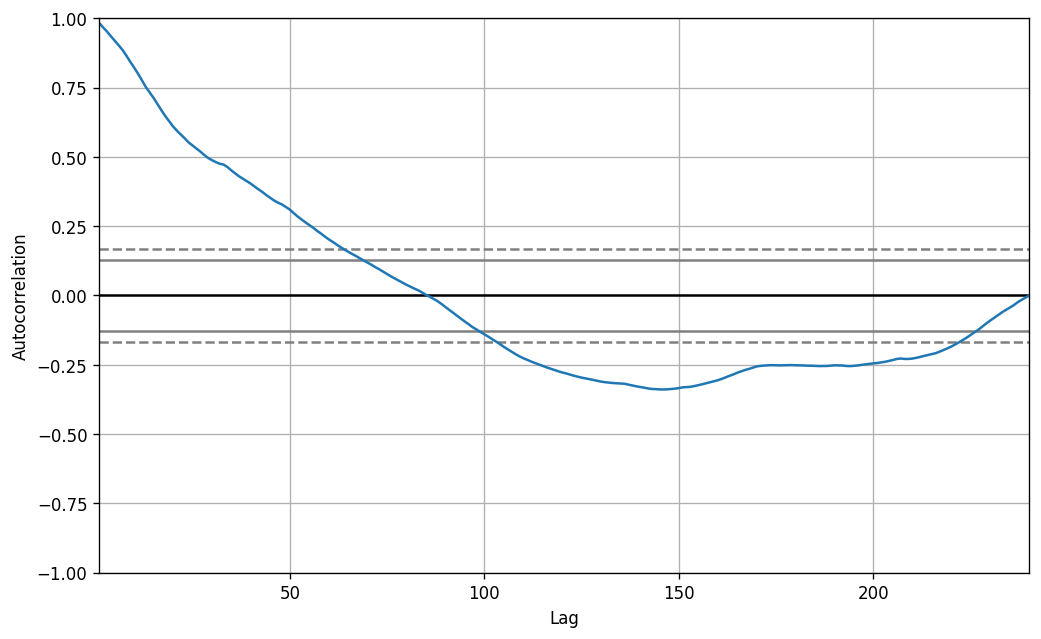

In [133]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(monthly_M2_SP['Low'].tolist())

# Stationarity and test for no White Noise

## Imports

In [134]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [135]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

## Low series

In [136]:
adf_test(monthly_M2_SP['Low'])
kpss_test(monthly_M2_SP['Low'])

Results of Dickey-Fuller Test:
Test Statistic                   0.346032
p-value                          0.979361
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64
Results of KPSS Test:
Test Statistic            1.882684
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Basic series non-stationary

### Log and diff

<Axes: xlabel='Date'>

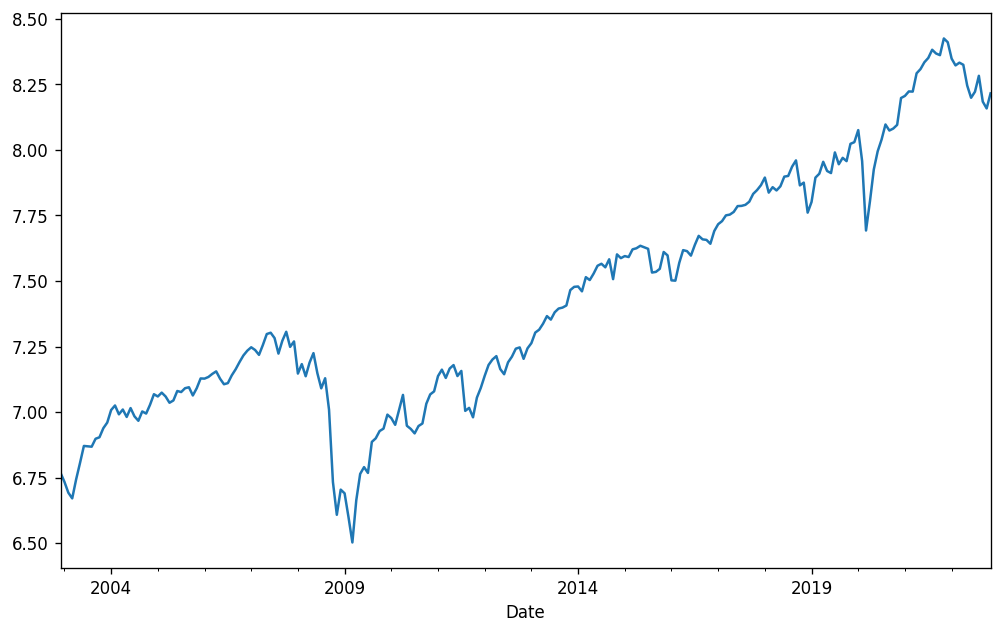

In [137]:
monthly_M2_SP['lnLow'] = np.log(monthly_M2_SP['Low'])
monthly_M2_SP['lnLow'].dropna().plot()

In [138]:
adf_test(monthly_M2_SP['lnLow'])
kpss_test(monthly_M2_SP['lnLow'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.777509
p-value                          0.825639
#Lags Used                       4.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64
Results of KPSS Test:
Test Statistic            2.003747
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Both tests show non-stationarity

<Axes: xlabel='Date'>

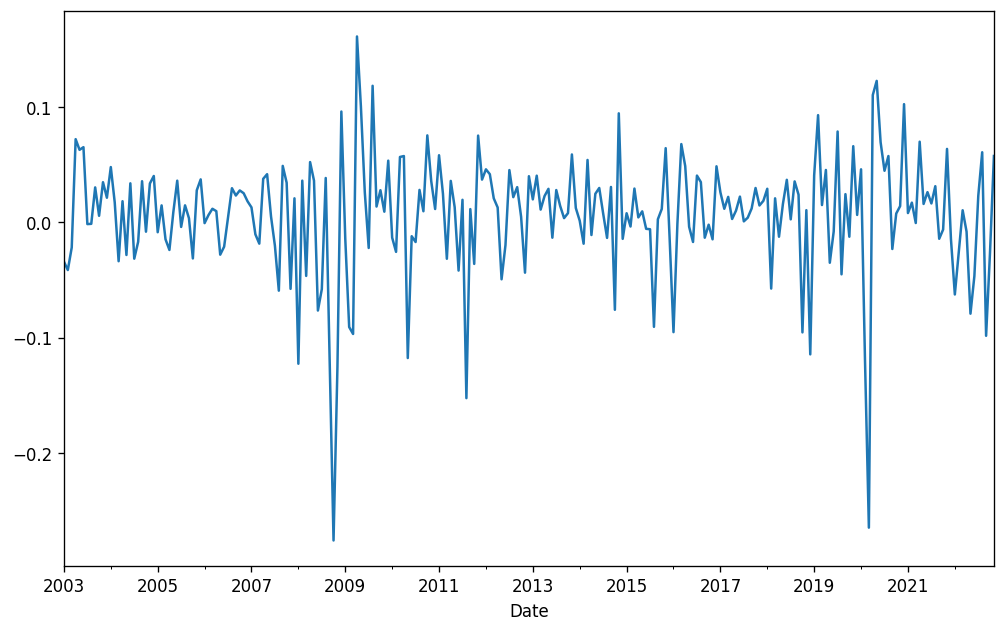

In [139]:
monthly_M2_SP['lnLow_diff1'] = monthly_M2_SP['lnLow']- monthly_M2_SP['lnLow'].shift(1)
monthly_M2_SP['lnLow_diff1'].dropna().plot()

In [140]:
adf_test(monthly_M2_SP['lnLow_diff1'].dropna())
kpss_test(monthly_M2_SP['lnLow_diff1'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -7.130375e+00
p-value                        3.530531e-10
#Lags Used                     3.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64
Results of KPSS Test:
Test Statistic           0.061323
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Both tests show stationarity

### Diff once

<Axes: xlabel='Date'>

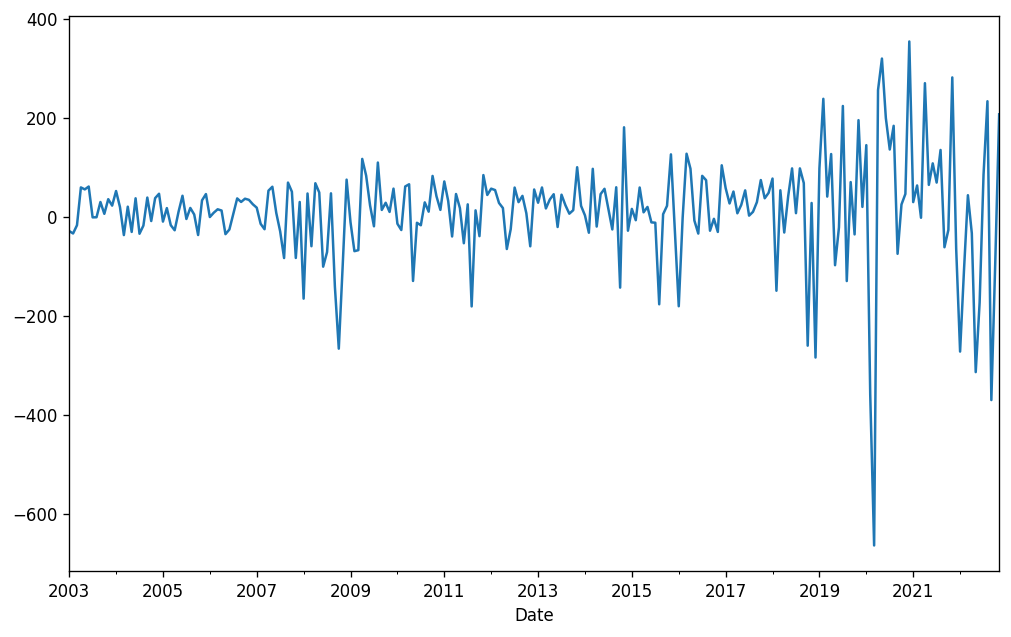

In [141]:
monthly_M2_SP['Low_diff1'] = monthly_M2_SP['Low']- monthly_M2_SP['Low'].shift(1)
monthly_M2_SP['Low_diff1'].dropna().plot()

In [142]:
adf_test(monthly_M2_SP['Low_diff1'].dropna())
kpss_test(monthly_M2_SP['Low_diff1'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -3.725432
p-value                          0.003769
#Lags Used                      14.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64
Results of KPSS Test:
Test Statistic            0.140005
p-value                   0.100000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


### White noise test Ljung-Box

In [143]:
sm.stats.acorr_ljungbox(monthly_M2_SP['Low_diff1'].dropna(), lags=range(1,12), return_df=True)

,lb_stat,lb_pvalue
1,1.370194,0.241779
2,8.995062,0.011136
3,11.090870,0.011245
4,13.308919,0.009861
5,14.426850,0.013114
6,14.704242,0.022686
7,14.960781,0.036505
8,18.365873,0.018645
9,19.622301,0.020392
10,19.783190,0.031371


## High series

In [144]:
adf_test(monthly_M2_SP['High'])
kpss_test(monthly_M2_SP['High'])

Results of Dickey-Fuller Test:
Test Statistic                   0.843066
p-value                          0.992300
#Lags Used                      12.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64
Results of KPSS Test:
Test Statistic            1.88173
p-value                   0.01000
Lags Used                10.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


Base series non-stationary

### Log and Diff

<Axes: xlabel='Date'>

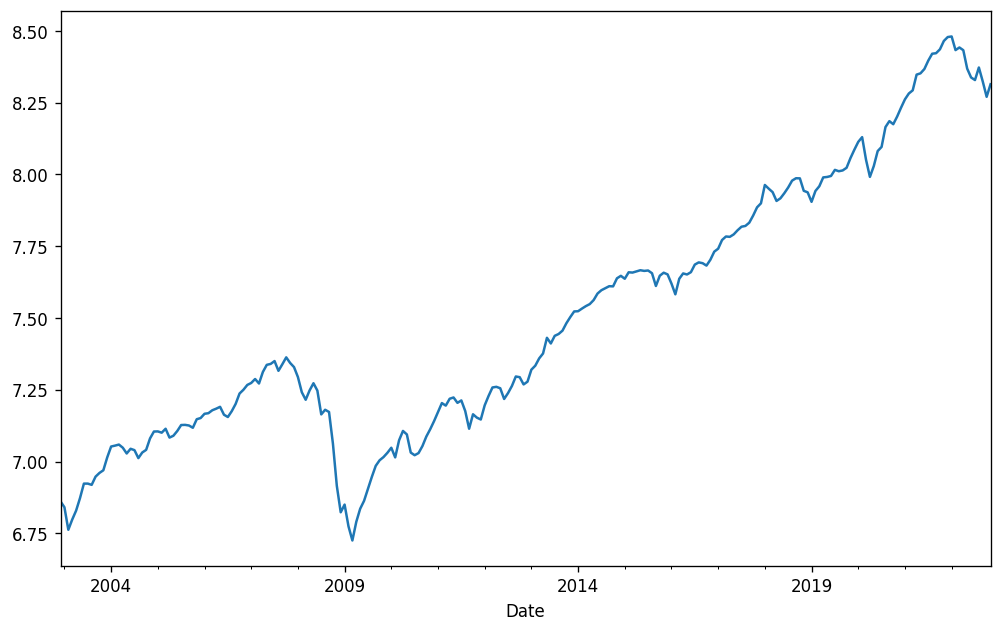

In [145]:
monthly_M2_SP['lnHigh'] = np.log(monthly_M2_SP['High'])
monthly_M2_SP['lnHigh'].dropna().plot()

In [146]:
adf_test(monthly_M2_SP['lnLow'])
kpss_test(monthly_M2_SP['lnLow'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.777509
p-value                          0.825639
#Lags Used                       4.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64
Results of KPSS Test:
Test Statistic            2.003747
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Both tests show non-stationarity

<Axes: xlabel='Date'>

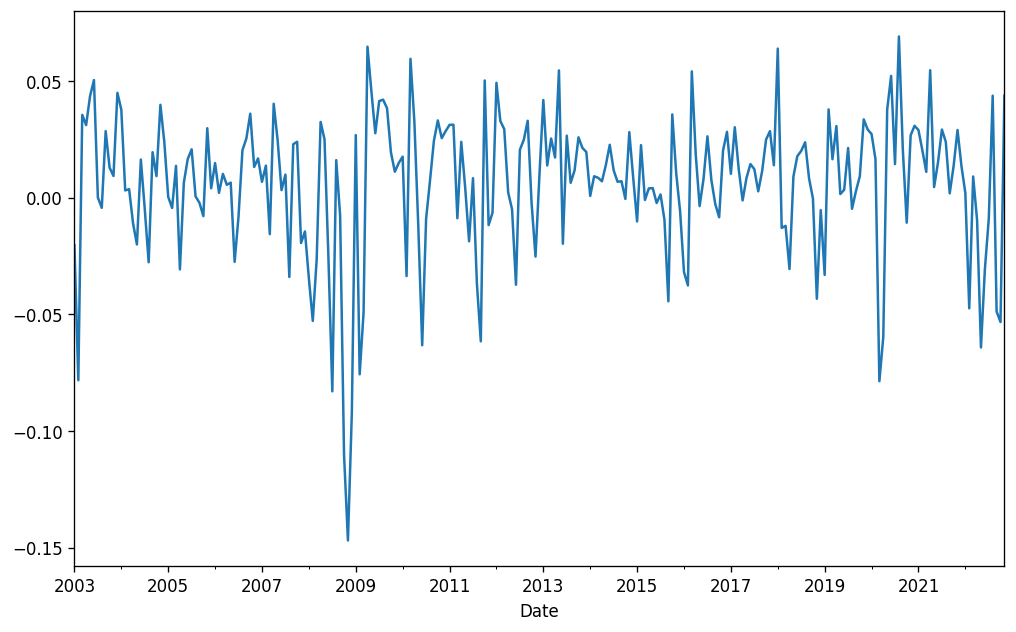

In [147]:
monthly_M2_SP['lnHigh_diff1'] = monthly_M2_SP['lnHigh']- monthly_M2_SP['lnHigh'].shift(1)
monthly_M2_SP['lnHigh_diff1'].dropna().plot()

In [148]:
adf_test(monthly_M2_SP['lnHigh_diff1'].dropna())
kpss_test(monthly_M2_SP['lnHigh_diff1'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -7.220218e+00
p-value                        2.120955e-10
#Lags Used                     2.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64
Results of KPSS Test:
Test Statistic           0.100976
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Both tests show stationarity

### White noise test Ljung-Box

In [149]:
sm.stats.acorr_ljungbox(monthly_M2_SP['lnHigh_diff1'].dropna(), lags=range(1,12), return_df=True)

,lb_stat,lb_pvalue
1,22.013547,0.000003
2,22.022840,0.000017
3,24.074925,0.000024
4,27.140233,0.000019
5,27.378124,0.000048
6,28.504048,0.000075
7,28.504409,0.000178
8,30.419870,0.000178
9,30.420413,0.000372
10,33.726077,0.000205


## M2 independent variable

In [150]:
adf_test(monthly_M2_SP['M2NS'])
kpss_test(monthly_M2_SP['M2NS'])

Results of Dickey-Fuller Test:
Test Statistic                   0.567865
p-value                          0.986796
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64
Results of KPSS Test:
Test Statistic            2.083662
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


ADF shows non-stationary, KPSS shows stationary

<Axes: xlabel='Date'>

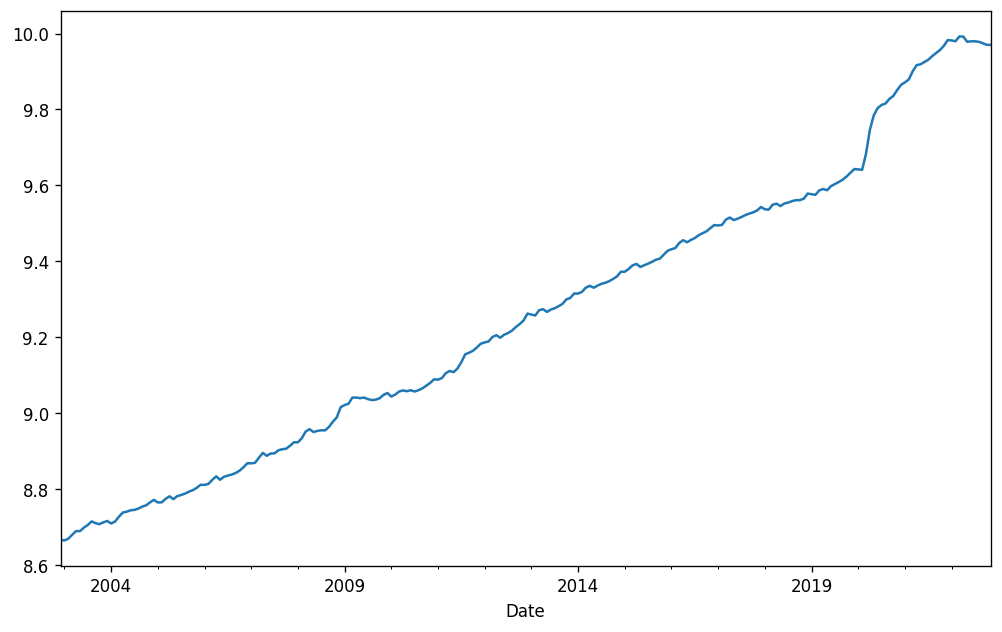

In [151]:
monthly_M2_SP['lnM2NS'] = np.log(monthly_M2_SP['M2NS'])
monthly_M2_SP['lnM2NS'].dropna().plot()

In [152]:
adf_test(monthly_M2_SP['lnM2NS'])
kpss_test(monthly_M2_SP['lnM2NS'])

Results of Dickey-Fuller Test:
Test Statistic                   0.444267
p-value                          0.983077
#Lags Used                      13.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64
Results of KPSS Test:
Test Statistic            2.236332
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<Axes: xlabel='Date'>

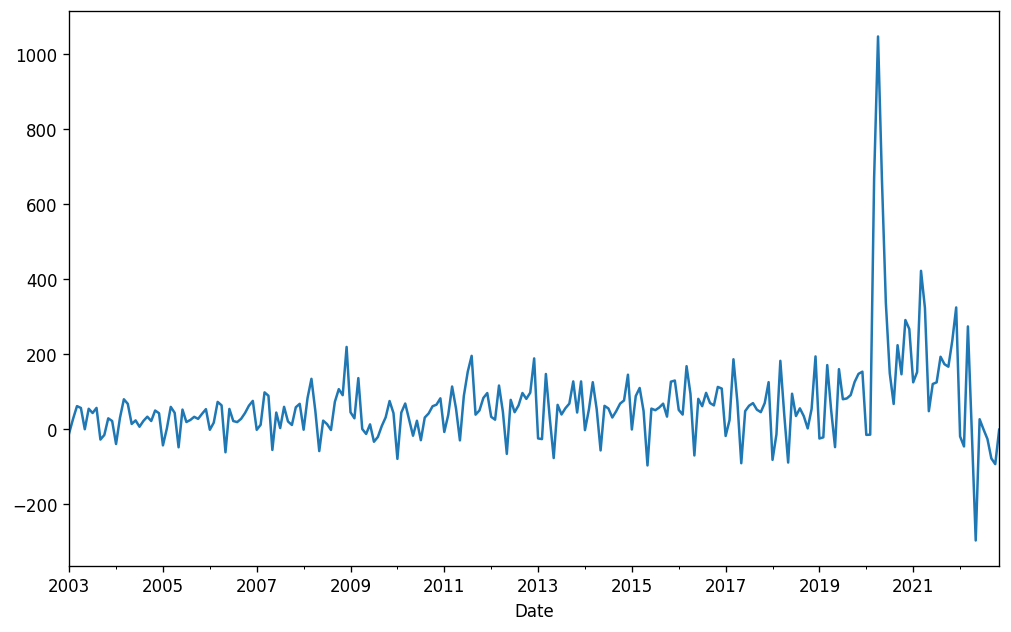

In [153]:
monthly_M2_SP['M2NS_diff1'] = monthly_M2_SP['M2NS']-monthly_M2_SP['M2NS'].shift(1)
monthly_M2_SP['M2NS_diff1'].dropna().plot()

In [154]:
adf_test(monthly_M2_SP['M2NS_diff1'].dropna())
kpss_test(monthly_M2_SP['M2NS_diff1'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -2.623665
p-value                          0.088204
#Lags Used                      13.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64
Results of KPSS Test:
Test Statistic           0.741368
p-value                  0.010000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


<Axes: xlabel='Date'>

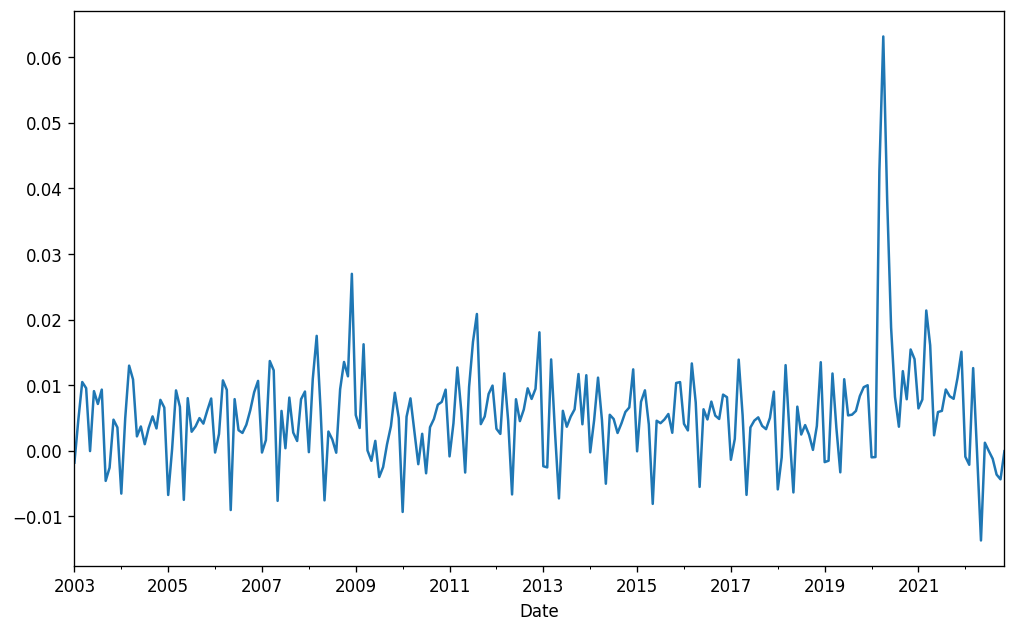

In [155]:
monthly_M2_SP['lnM2NS_diff1'] = monthly_M2_SP['lnM2NS']-monthly_M2_SP['lnM2NS'].shift(1)
monthly_M2_SP['lnM2NS_diff1'].dropna().plot()

In [156]:
adf_test(monthly_M2_SP['lnM2NS_diff1'].dropna())
kpss_test(monthly_M2_SP['lnM2NS_diff1'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -3.579939
p-value                          0.006156
#Lags Used                      12.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64
Results of KPSS Test:
Test Statistic           0.230992
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [157]:
sm.stats.acorr_ljungbox(monthly_M2_SP['lnM2NS_diff1'].dropna(), lags=range(1,12), return_df=True)

,lb_stat,lb_pvalue
1,33.377938,7.587990e-09
2,33.383414,5.634868e-08
3,39.371116,1.448231e-08
4,45.333100,3.389826e-09
5,45.340961,1.236792e-08
6,46.230322,2.663849e-08
7,46.230820,7.882830e-08
8,52.166283,1.563139e-08
9,57.256452,4.513132e-09
10,59.628489,4.260799e-09


Difference of logarithms passes both tests for stationarity

## Stationarity results
High series should be converted to difference of logarithms in order to achieve stationarity and not a white noise

Low series should be differentiated once to achieve stationarity and not a white noise

M2 series should be converted to difference of logarithms in order to achieve stationarity and not a white noise 

# Standarisation

In [158]:
FEATURES.append('lnM2NS_diff1')
monthly_M2_SP.dropna(inplace=True)
X_train = monthly_M2_SP[FEATURES][:-12]
X_train.drop('M2NS',axis=1,inplace=True)
X_train = (X_train-X_train.mean())/X_train.std()
y_train = monthly_M2_SP[['Low_diff1','lnHigh_diff1']][:-12]
y_train = (y_train-y_train.mean())/y_train.std()
X_test = monthly_M2_SP[FEATURES][-12:]
X_test.drop('M2NS',axis=1,inplace=True)
X_test = (X_test-X_test.mean())/X_test.std()
y_test = monthly_M2_SP[['Low_diff1','lnHigh_diff1']][-12:]
# save mean and std to recover plots later
mL = y_test['Low_diff1'].mean()
sL = y_test['Low_diff1'].std()
y_test['Low_diff1'] = (y_test['Low_diff1']-mL)/sL
mH = y_test['lnHigh_diff1'].mean()
sH = y_test['lnHigh_diff1'].std()
y_test['lnHigh_diff1'] = (y_test['lnHigh_diff1']-mH)/sH


# VARMAX

## Choosing p and q

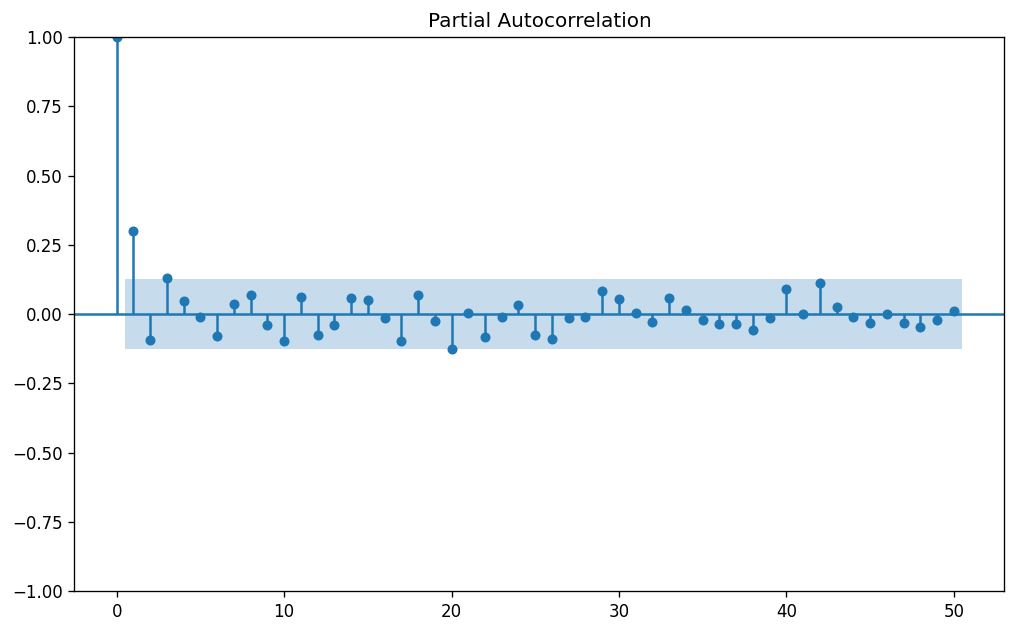

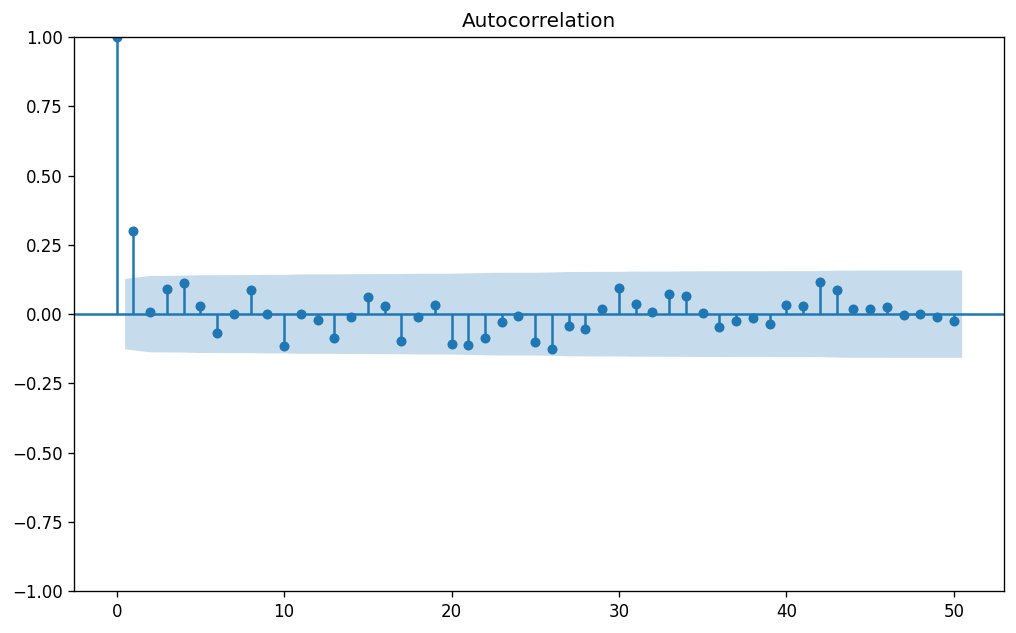

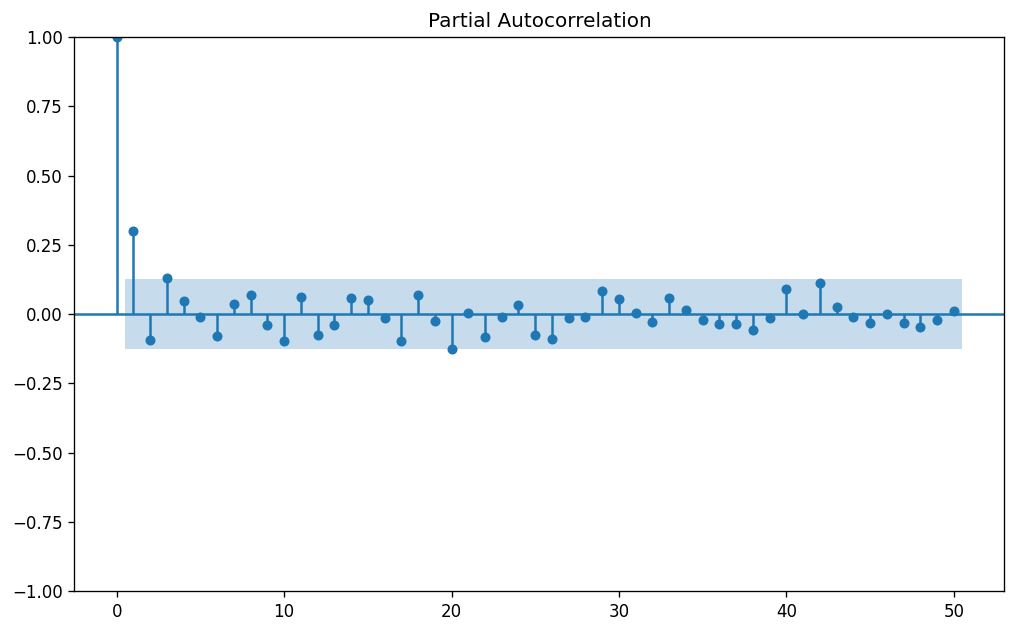

In [93]:
sm.graphics.tsa.plot_acf(monthly_M2_SP["lnHigh_diff1"].values.squeeze(), lags=50)
sm.graphics.tsa.plot_pacf(monthly_M2_SP["lnHigh_diff1"].values.squeeze(), lags=50, method="ywm")

Box-Jenkins p=2 q=2

## Model choice

In [94]:
import itertools
import warnings

In [95]:

p = range(0,4)
q = range(0,4)
# for already differentiated series
pq = list(itertools.product(p, q))

We use train set without last 12 months and test set last 12 months

In [97]:
warnings.filterwarnings("ignore")
varmax_comparison = pd.DataFrame(columns=['p','q','AIC','BIC'])
for param in pq[1:]:
    try: 
        mod = sm.tsa.VARMAX(endog=y_train,
                                        exog=X_train,
                                        trend='n',
                                        order=param)

        results = mod.fit(maxiter=1000)
        varmax_comparison.loc[len(varmax_comparison.index)] = [param[0],param[1],results.aic,results.bic]
    except:
        varmax_comparison.loc[len(varmax_comparison.index)] = [param[0],param[1],None,None]
        print(f"Error for p {param[0]}, q{param[1]}")
    varmax_comparison.to_csv('./data/outputs/varmax_comparison_extended_monthly.csv')
    print(f"Iteration finished for {param}")

Iteration finished for (0, 1)
Iteration finished for (0, 2)
Iteration finished for (0, 3)
Iteration finished for (1, 0)
Iteration finished for (1, 1)
Iteration finished for (1, 2)
Iteration finished for (1, 3)
Iteration finished for (2, 0)
Iteration finished for (2, 1)
Iteration finished for (2, 2)
Iteration finished for (2, 3)
Iteration finished for (3, 0)
Iteration finished for (3, 1)
Iteration finished for (3, 2)
Iteration finished for (3, 3)


In [98]:
# varmax_comparison.to_csv('./data/outputs/varmax_comparison_M2_SP.csv')
varmax_comparison.sort_values(by=['AIC']).head()


,p,q,AIC,BIC
14,3.0,3.0,1082.292634,1250.115185
10,2.0,3.0,1083.048205,1237.170955
13,3.0,2.0,1088.862253,1242.985004
9,2.0,2.0,1089.469432,1229.892382
8,2.0,1.0,1090.612990,1217.336140


# Final Model and summary

Basing on AIC we choose p=3 and q=3

In [99]:
mod = sm.tsa.VARMAX(endog=y_train,
                            exog=X_train,
                            trend='n',
                            order=(3,3))

results = mod.fit(maxiter=10000)
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:     ['Low_diff1', 'lnHigh_diff1']   No. Observations:                  227
Model:                               VARMAX(3,3)   Log Likelihood                -492.146
Date:                           Sat, 22 Apr 2023   AIC                           1082.293
Time:                                   23:44:31   BIC                           1250.115
Sample:                               01-01-2003   HQIC                          1150.011
                                    - 11-01-2021                                         
Covariance Type:                             opg                                         
Ljung-Box (L1) (Q):             0.17, 0.24   Jarque-Bera (JB):         72.98, 39.39
Prob(Q):                        0.68, 0.62   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         3.46, 0.60   Skew:                     -0.70, -0.27
Prob(H) (two-sided):        

In [100]:
for table in results.summary().tables:
    print('#################################################')
    print(table.as_latex_tabular())

#################################################
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   & ['Low\_diff1', 'lnHigh\_diff1'] & \textbf{  No. Observations:  } &   227     \\
\textbf{Model:}           &           VARMAX(3,3)           & \textbf{  Log Likelihood     } & -492.146  \\
\textbf{Date:}            &         Sat, 22 Apr 2023        & \textbf{  AIC                } & 1082.293  \\
\textbf{Time:}            &             23:46:58            & \textbf{  BIC                } & 1250.115  \\
\textbf{Sample:}          &            01-01-2003           & \textbf{  HQIC               } & 1150.011  \\
\textbf{}                 &           - 11-01-2021          & \textbf{                     } &           \\
\textbf{Covariance Type:} &               opg               & \textbf{                     } &           \\
\bottomrule
\end{tabular}
%\caption{Statespace Model Results}
\end{center}
#################################################
\begin{center}
\begin{t

# Prediction

In [160]:
frcst = results.forecast(steps=12, exog=X_test)
# reverse standarisation
frcst['Low_diff1'] = frcst['Low_diff1'] * sL + mL
frcst['lnHigh_diff1'] = frcst['lnHigh_diff1'] * sH + mH

frcst['Low'] = monthly_M2_SP['Low'][-13] + np.cumsum(frcst['Low_diff1'])
frcst['High'] = np.exp(monthly_M2_SP["lnHigh"][-13] + np.cumsum(frcst['lnHigh_diff1']))
frcst

,Low_diff1,lnHigh_diff1,Low,High
2021-12-01,91.254888,0.046149,4651.254888,4967.883609
2022-01-01,-357.675293,-0.012215,4293.579595,4907.568998
2022-02-01,-174.433608,-0.049470,4119.145988,4670.701098
2022-03-01,-101.913883,-0.031253,4017.232105,4526.984744
2022-04-01,-103.284695,-0.024330,3913.947410,4418.173891
2022-05-01,-59.562310,-0.018427,3854.385100,4337.506654
2022-06-01,-5.260435,-0.017945,3849.124665,4260.364859
2022-07-01,-140.084196,-0.027027,3709.040469,4146.760021
2022-08-01,192.670817,-0.011353,3901.711286,4099.948665
2022-09-01,9.376996,0.018769,3911.088282,4177.626522


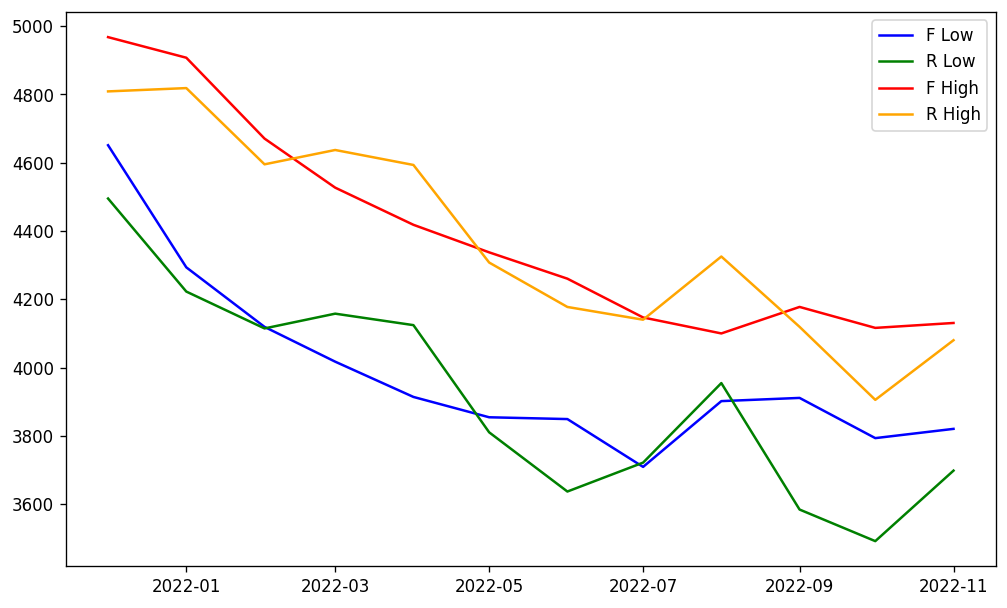

In [161]:
fig, ax = plt.subplots()
ax.plot(frcst['Low'], "b", label="F Low")
ax.plot(monthly_M2_SP['Low'][-12:], "g", label="R Low")
ax.plot(frcst['High'], "r", label="F High")
ax.plot(monthly_M2_SP['High'][-12:], "orange", label="R High")
ax.legend(loc="best")

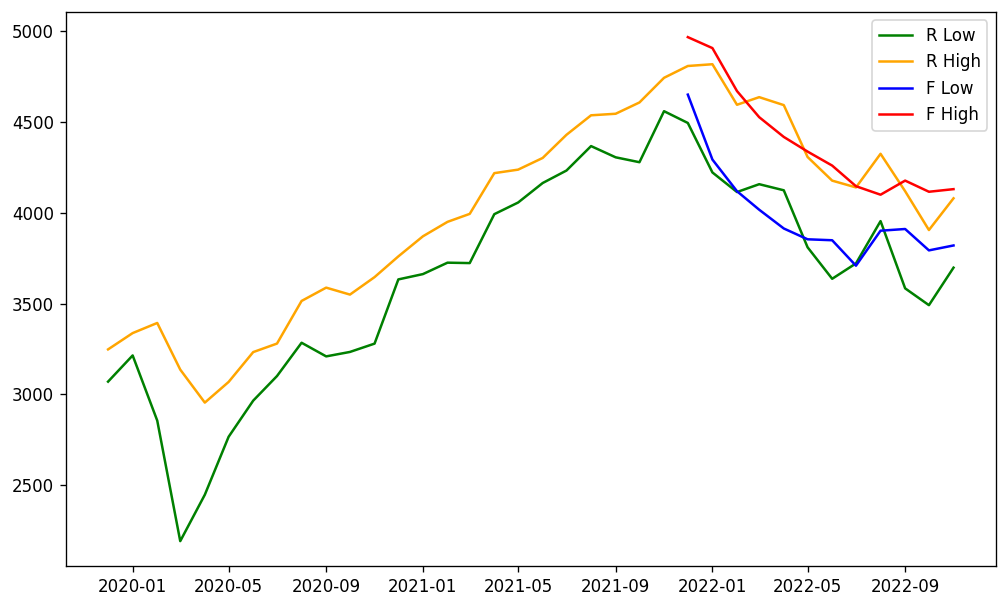

In [163]:
fig, ax = plt.subplots()
ax.plot(monthly_M2_SP['Low'][-36:], "g", label="R Low")
ax.plot(monthly_M2_SP['High'][-36:], "orange", label="R High")
ax.plot(frcst['Low'], "b", label="F Low")
ax.plot(frcst['High'], "r", label="F High")
ax.legend(loc="best")

In [164]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def MAPE(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

In [165]:
print("########### Low ###########")
print('MRSE ', mean_squared_error(monthly_M2_SP['Low'][-12:],frcst['Low']))
print('MAE ', mean_absolute_error(monthly_M2_SP['Low'][-12:],frcst['Low']))
print('MAPE ', MAPE(monthly_M2_SP['Low'][-12:],frcst['Low']))
print("########### High ###########")
print('MRSE ', mean_squared_error(monthly_M2_SP['High'][-12:],frcst['High']))
print('MAE ', mean_absolute_error(monthly_M2_SP['High'][-12:],frcst['High']))
print('MAPE ', MAPE(monthly_M2_SP['High'][-12:],frcst['High']))

########### Low ###########
MRSE  29691.089170718045
MAE  137.93243495147397
MAPE  3.623401429208903
########### High ###########
MRSE  15892.654243768426
MAE  106.09673940811312
MAPE  2.423627064424308
